<a href="https://colab.research.google.com/github/NLP4/Enhacing-SPECTER-with-some-extensions/blob/main/Exploring_the_Generalizability_of_SPECTER_for_Text_Classification_Tasks__TRIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.2.0-py3-none-any.whl (1.8 MB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  Using cached tokenizers-0.9.4.tar.gz (184 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-w

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.

Evaluating SPECTER...
SPECTER Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       0.85      0.81      0.83        27
           2       0.80      0.65      0.72        37
           3       0.81      0.91      0.85        97

    accuracy                           0.83       200
   macro avg       0.84      0.80      0.82       200
weighted avg       0.83      0.83      0.83       200

SPECTER Accuracy: 0.8300



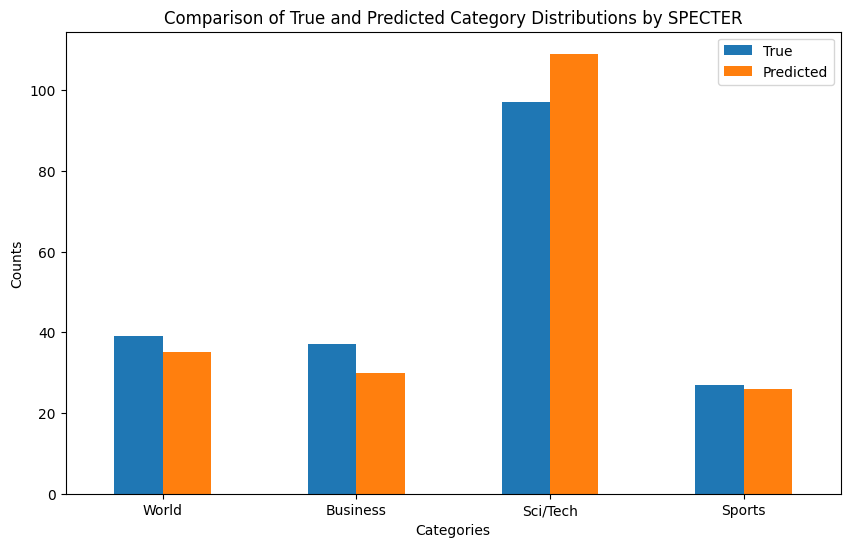

Evaluating RoBERTa...
RoBERTa Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        39
           1       0.96      0.85      0.90        27
           2       0.81      0.59      0.69        37
           3       0.83      0.94      0.88        97

    accuracy                           0.86       200
   macro avg       0.88      0.83      0.85       200
weighted avg       0.86      0.86      0.86       200

RoBERTa Accuracy: 0.8600



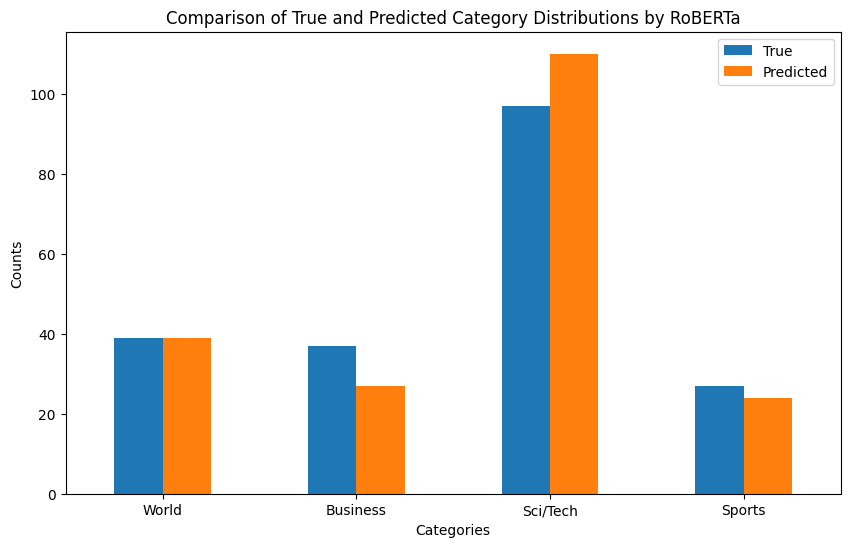

Evaluating BERT...
BERT Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        39
           1       0.96      0.89      0.92        27
           2       0.77      0.65      0.71        37
           3       0.81      0.89      0.85        97

    accuracy                           0.82       200
   macro avg       0.84      0.80      0.82       200
weighted avg       0.83      0.82      0.82       200

BERT Accuracy: 0.8250



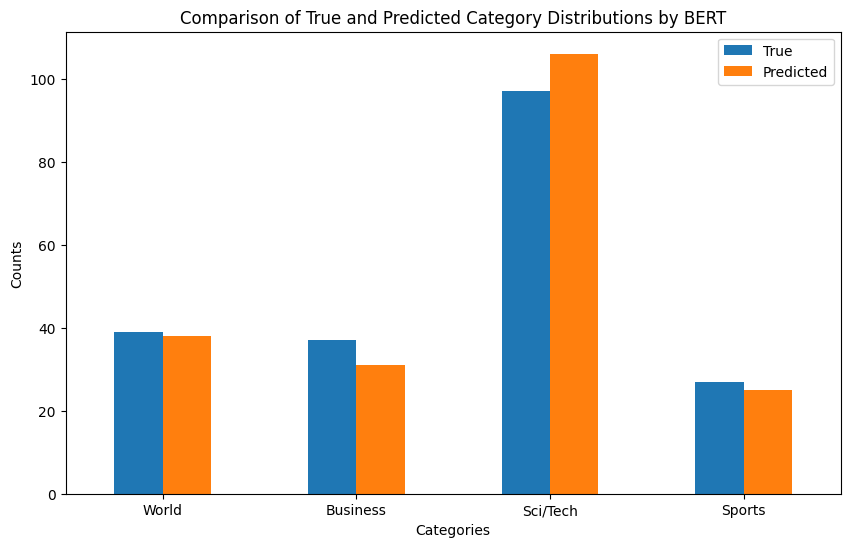

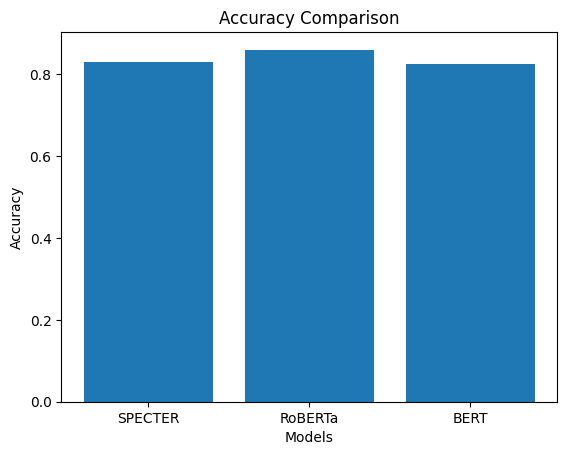

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
!pip install transformers
!pip install --upgrade transformers==4.2
from transformers import AutoTokenizer, AutoModel, RobertaTokenizer, RobertaModel
import torch
!pip install datasets
from datasets import load_dataset
!pip install seaborn
!pip install -U scikit-learn
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the AG News dataset
ag_news_dataset = load_dataset('ag_news', split='train[:1000]') # set to 1000 as default, increase for higher accuracy, decrase for faster training
texts = ag_news_dataset['text']
targets = ag_news_dataset['label']

# Load models and tokenizers
specter_tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
specter_model = AutoModel.from_pretrained('allenai/specter')

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')

models = [
    ('SPECTER', specter_model, specter_tokenizer),
    ('RoBERTa', roberta_model, roberta_tokenizer),
    ('BERT', bert_model, bert_tokenizer)
]

# Function to evaluate a model using logistic regression and return the classification report, classifier, and accuracy
def evaluate_model(embeddings, targets):
    X_train, X_test, y_train, y_test = train_test_split(embeddings, targets, test_size=0.2, random_state=42)
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return report, classifier, X_test, y_test, accuracy, y_pred

# Function to compare models using classification reports and plot evaluation metrics
def compare_models(models, texts, targets):
    reports = []
    accuracies = []

    for model_name, model, tokenizer in models:
        print(f"Evaluating {model_name}...")

        # Tokenize and obtain embeddings
        inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()

        # Evaluate model and obtain classification report
        report, classifier, X_test, y_test, accuracy, y_pred = evaluate_model(embeddings, targets)
        reports.append(report)
        accuracies.append(accuracy)

        print(f"{model_name} Classification Report:")
        print(report)
        print(f"{model_name} Accuracy: {accuracy:.4f}\n")

        # Count occurrences of each category in the real dataset and the predictions
        true_counts = Counter(y_test)
        pred_counts = Counter(y_pred)

        # Create a DataFrame containing the counts of the true and predicted categories
        counts_df = pd.DataFrame({'True': true_counts, 'Predicted': pred_counts}).reset_index()
        counts_df['index'] = counts_df['index'].replace({0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'})
        counts_df = counts_df.set_index('index')

        # Plot the bar chart comparing the true and predicted category distributions
        ax = counts_df.plot.bar(rot=0, figsize=(10, 6))
        plt.title(f'Comparison of True and Predicted Category Distributions by {model_name}')
        plt.xlabel('Categories')
        plt.ylabel('Counts')
        plt.legend(loc='upper right')
        plt.show()

    # Plot accuracy comparison
    plt.bar([m[0] for m in models], accuracies)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.show()

    return reports

target_names = np.unique(targets)
classification_reports = compare_models(models, texts, targets)

